# Data Science Final Project

### Nathan DuPont, Trenton Bowser, David Schulz

---

## Research Question

How do different customer and company usage metrics relate to customer retention rates with the bank in this study?

## Hypothesis

Customers with higher utilization of credit card services will have lower attrition rates when compared to customers with lower utilization rates.

## Dataset

Our dataset contains a list of customers using Credit Card services from a bank. The specific bank is unknown, and the dataset[[1]](https://www.kaggle.com/sakshigoyal7/credit-card-customers) originates from Data Science site LEAP[[2]](https://leaps.analyttica.com/).

The features present in the dataset are different metrics from customers, which can be divided into several different categories:
- Personal metrics – Age, Gender, Education, Income, etc.
- Service utilization – Months on book, Total transactions, Months inactive, etc.
- Target Variable – Whether a customer churned or not (“Attrition_Flag”)

This dataset contains roughly 10,000 customer entries, with 19 raw features. It was reportedly created by a bank manager seeking to understand increases in customer attrition rates, and wanted to find out why customers were leaving and what factors led to customer attrition, and how to predict it.


---
## Data Preprocessing

Import libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Load in the Bank Churners dataset.

In [2]:
df_bank = pd.read_csv("BankChurners.csv")

In [3]:
df_bank.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Set certain features to categorical.

In [4]:
df_bank['Attrition_Flag'] = df_bank['Attrition_Flag'].astype('category')
df_bank['Gender'] = df_bank['Gender'].astype('category')
df_bank['Education_Level'] = df_bank['Education_Level'].astype('category')
df_bank['Marital_Status'] = df_bank['Marital_Status'].astype('category')
df_bank['Income_Category'] = df_bank['Income_Category'].astype('category')
df_bank['Card_Category'] = df_bank['Card_Category'].astype('category')

Drops column of the unique client numbers since they differ for every customer and don't add any value to determining a customer churn. Deleting the last two columns since they are not actual features.

In [5]:
df_clean = df_bank.drop(df_bank.columns[[0, 21, 22]], axis=1)

Checking for missing values in the dataset.

In [6]:
df_clean.isna().any()

Attrition_Flag              False
Customer_Age                False
Gender                      False
Dependent_count             False
Education_Level             False
Marital_Status              False
Income_Category             False
Card_Category               False
Months_on_book              False
Total_Relationship_Count    False
Months_Inactive_12_mon      False
Contacts_Count_12_mon       False
Credit_Limit                False
Total_Revolving_Bal         False
Avg_Open_To_Buy             False
Total_Amt_Chng_Q4_Q1        False
Total_Trans_Amt             False
Total_Trans_Ct              False
Total_Ct_Chng_Q4_Q1         False
Avg_Utilization_Ratio       False
dtype: bool

At first glance it appears that the data contains no missing values. However, after analyzing some of the categorical variables, we realized that Education_Level, Marital_Status, and Income_Category all contained categories of 'Unknown'. So we made a new DataFrame with these unknown values removed.

In [7]:
df_clean_full = df_clean.copy()
df_clean['Education_Level'] = df_clean['Education_Level'].replace('Unknown', np.nan)
df_clean['Marital_Status'] = df_clean['Marital_Status'].replace('Unknown', np.nan)
df_clean['Income_Category'] = df_clean['Income_Category'].replace('Unknown', np.nan)
df_clean = df_clean.dropna()

To make it easier for our models to utilize the data, we need to encode it properly. For binary categorical variables (Attrition and Gender), this is being set to a single value (0 or 1). For the remaining categorical variables, they are being transformed with one-hot encoding (through the use of dummies) to capture all values.

In [8]:
def set_dummy_categories(df):
    df_dummies = df.copy()

    # Check and see if a customer has churned
    bool_attrition = df_dummies['Attrition_Flag'] == 'Attrited Customer'

    # Change the values from strings to integers
    df_dummies['Attrition_Flag'] = bool_attrition.astype('int32');


    # Check to see the gender of a customer
    bool_gender = df_dummies['Gender'] == 'M'

    # Change the values from strings to integers
    df_dummies['Gender'] = bool_gender.astype('int32');

    df_dummies = pd.get_dummies(df_dummies, 
                                columns=['Education_Level', 
                                         'Marital_Status', 
                                         'Income_Category', 
                                         'Card_Category'])

    return df_dummies

In [9]:
df_clean_dummies = set_dummy_categories(df_clean)
df_clean_dummies_full = set_dummy_categories(df_clean_full)

df_clean_dummies.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,1,3,39,5,1,3,12691.0,777,...,0,0,1,0,0,0,1,0,0,0
1,0,49,0,5,44,6,1,2,8256.0,864,...,0,0,0,0,1,0,1,0,0,0
2,0,51,1,3,36,4,1,0,3418.0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,40,1,3,21,5,1,0,4716.0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,44,1,2,36,3,1,2,4010.0,1247,...,0,1,0,0,0,0,1,0,0,0


---

## Data Analysis and Visualization

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7081 entries, 0 to 10126
Data columns (total 20 columns):
Attrition_Flag              7081 non-null category
Customer_Age                7081 non-null int64
Gender                      7081 non-null category
Dependent_count             7081 non-null int64
Education_Level             7081 non-null category
Marital_Status              7081 non-null category
Income_Category             7081 non-null category
Card_Category               7081 non-null category
Months_on_book              7081 non-null int64
Total_Relationship_Count    7081 non-null int64
Months_Inactive_12_mon      7081 non-null int64
Contacts_Count_12_mon       7081 non-null int64
Credit_Limit                7081 non-null float64
Total_Revolving_Bal         7081 non-null int64
Avg_Open_To_Buy             7081 non-null float64
Total_Amt_Chng_Q4_Q1        7081 non-null float64
Total_Trans_Amt             7081 non-null int64
Total_Trans_Ct              7081 non-null int64
Tota

Count of the customer attrition to visualize the different in dataset size.

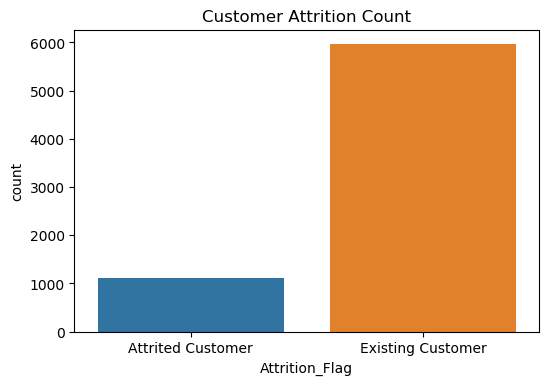

In [11]:
plt.rcParams['figure.dpi'] = 100
sns.countplot(data=df_clean, x='Attrition_Flag').set_title('Customer Attrition Count')
plt.show()

Count of the customer attrition shows us that a large imbalance in class size exists attrited and existing customers.

Visualization of some of the numerical features versus a customers attrition.

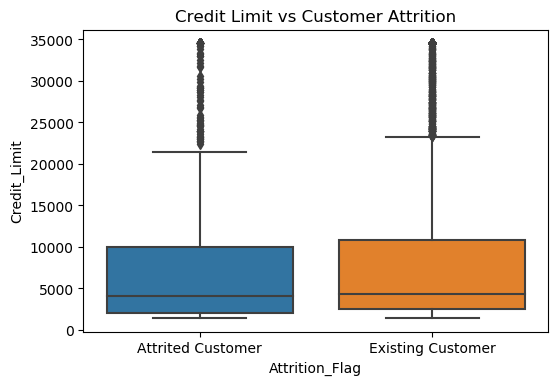

In [12]:
sns.boxplot(data=df_clean, x='Attrition_Flag', y='Credit_Limit').set_title('Credit Limit vs Customer Attrition')
plt.show()

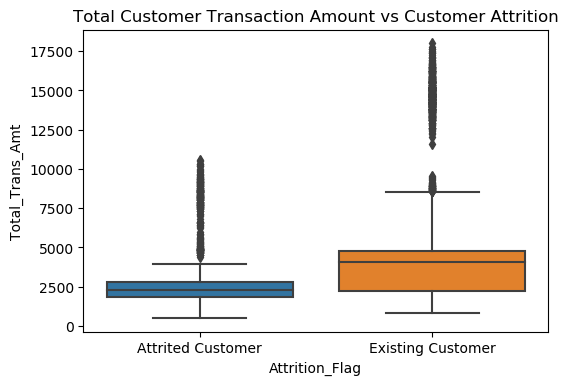

In [13]:
sns.boxplot(data=df_clean, x='Attrition_Flag', y='Total_Trans_Amt').set_title('Total Customer Transaction Amount vs Customer Attrition')
plt.show()

The total customer transaction amount seems to be higher for existing customers.

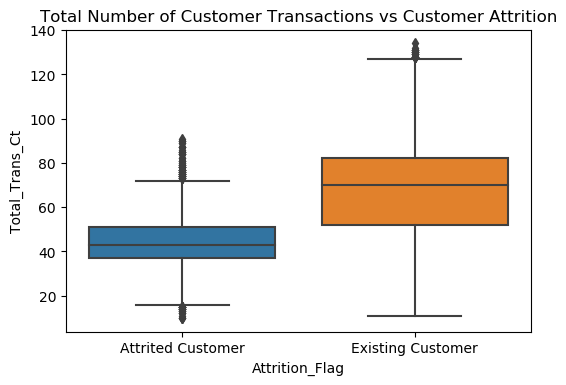

In [14]:
sns.boxplot(data=df_clean, x='Attrition_Flag', y='Total_Trans_Ct').set_title('Total Number of Customer Transactions vs Customer Attrition')
plt.show()

The total number of customer transactions is much higher for existing customers.

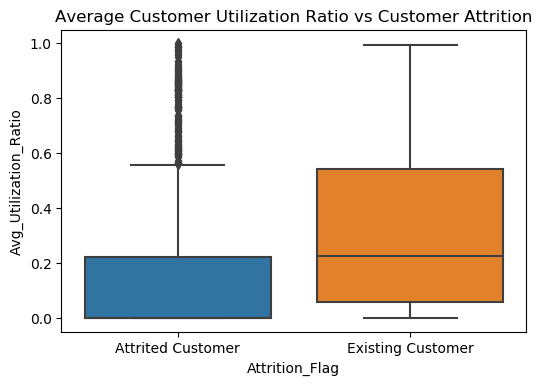

In [15]:
sns.boxplot(data=df_clean, x='Attrition_Flag', y='Avg_Utilization_Ratio').set_title('Average Customer Utilization Ratio vs Customer Attrition')
plt.show()

Existing customers also seem to have a higher utilization ratio when compared to attrited customers supporting our hypothesis.

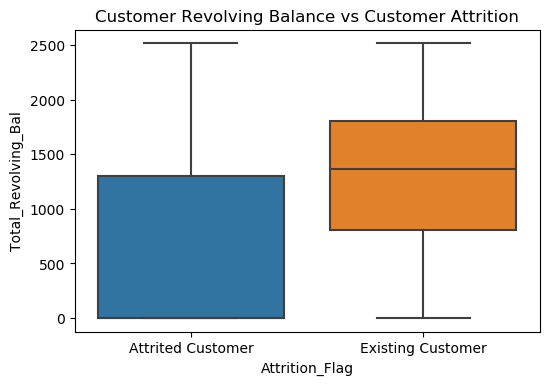

In [16]:
sns.boxplot(data=df_clean, x='Attrition_Flag', y='Total_Revolving_Bal').set_title('Customer Revolving Balance vs Customer Attrition')
plt.show()

The existing customers also seem to have an overall higher revolving balance than attrited customers.

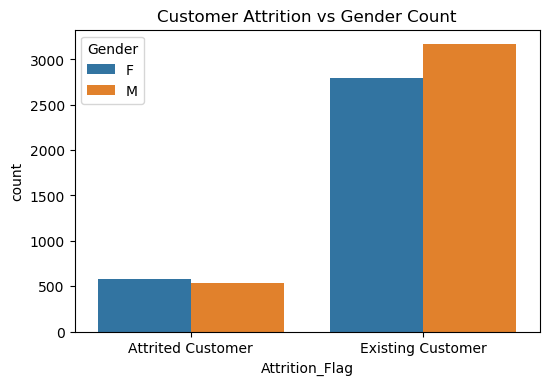

In [19]:
sns.countplot(data=df_clean, x='Attrition_Flag', hue='Gender').set_title('Customer Attrition vs Gender Count')
plt.show()

Male customers seem to be more likely to stay with the bank and female customers are more likely to leave.

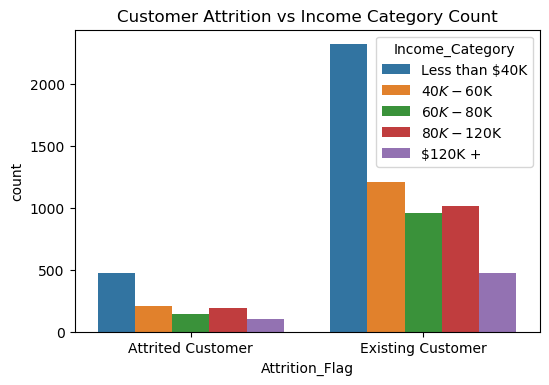

In [17]:
sns.countplot(data=df_clean, x='Attrition_Flag', hue='Income_Category', 
              hue_order=['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']
             ).set_title('Customer Attrition vs Income Category Count')
plt.show()

Running the Kruskal-Wallis statistical test to discover associations between customer attribution and our various numerical variables.

In [20]:
age_samples = []
dependent_samples = []
month_book_samples = []
relationship_count_samples = []
month_inactive_samples = []
contacts_count_samples = []
credit_limit_samples = []
revolving_bal_samples = []
open_to_buy_samples = []
amt_q4_q1_samples = []
trans_amt_samples = []
trans_ct_samples = []
ct_q4_q1_samples = []
utilization_samples = []
for value in set(df_clean["Attrition_Flag"]):
    mask = df_clean["Attrition_Flag"] == value
    age_samples.append(df_clean["Customer_Age"][mask])
    dependent_samples.append(df_clean["Dependent_count"][mask])
    month_book_samples.append(df_clean["Months_on_book"][mask])
    relationship_count_samples.append(df_clean["Total_Relationship_Count"][mask])
    month_inactive_samples.append(df_clean["Months_Inactive_12_mon"][mask])
    contacts_count_samples.append(df_clean["Contacts_Count_12_mon"][mask])
    credit_limit_samples.append(df_clean["Credit_Limit"][mask])
    revolving_bal_samples.append(df_clean["Total_Revolving_Bal"][mask])
    open_to_buy_samples.append(df_clean["Avg_Open_To_Buy"][mask])
    amt_q4_q1_samples.append(df_clean["Total_Amt_Chng_Q4_Q1"][mask])
    trans_amt_samples.append(df_clean["Total_Trans_Amt"][mask])
    trans_ct_samples.append(df_clean["Total_Trans_Ct"][mask])
    ct_q4_q1_samples.append(df_clean["Total_Ct_Chng_Q4_Q1"][mask])
    utilization_samples.append(df_clean["Avg_Utilization_Ratio"][mask])
p_values = np.zeros(19)
_, p_values[0] = stats.kruskal(*age_samples)
_, p_values[1] = stats.kruskal(*dependent_samples)
_, p_values[2] = stats.kruskal(*month_book_samples)
_, p_values[3] = stats.kruskal(*relationship_count_samples)
_, p_values[4] = stats.kruskal(*month_inactive_samples)
_, p_values[5] = stats.kruskal(*contacts_count_samples)
_, p_values[6] = stats.kruskal(*credit_limit_samples)
_, p_values[7] = stats.kruskal(*revolving_bal_samples)
_, p_values[8] = stats.kruskal(*open_to_buy_samples)
_, p_values[9] = stats.kruskal(*amt_q4_q1_samples)
_, p_values[10] = stats.kruskal(*trans_amt_samples)
_, p_values[11] = stats.kruskal(*trans_ct_samples)
_, p_values[12] = stats.kruskal(*ct_q4_q1_samples)
_, p_values[13] = stats.kruskal(*utilization_samples)

Performing a Chi-squared test of independence to test associations between customer attribution and our categorical variables.

In [21]:
combination_counts = df_clean[["Attrition_Flag","Gender"]].groupby(by=["Attrition_Flag","Gender"]).size().unstack(level=0)
_, p_values[14], _, _ = stats.chi2_contingency(combination_counts)
combination_counts = df_clean[["Attrition_Flag","Education_Level"]].groupby(by=["Attrition_Flag","Education_Level"]).size().unstack(level=0)
_, p_values[15], _, _ = stats.chi2_contingency(combination_counts)
combination_counts = df_clean[["Attrition_Flag","Marital_Status"]].groupby(by=["Attrition_Flag","Marital_Status"]).size().unstack(level=0)
_, p_values[16], _, _ = stats.chi2_contingency(combination_counts)
combination_counts = df_clean[["Attrition_Flag","Income_Category"]].groupby(by=["Attrition_Flag","Income_Category"]).size().unstack(level=0)
_, p_values[17], _, _ = stats.chi2_contingency(combination_counts)
combination_counts = df_clean[["Attrition_Flag","Card_Category"]].groupby(by=["Attrition_Flag","Card_Category"]).size().unstack(level=0)
_, p_values[18], _, _ = stats.chi2_contingency(combination_counts)

Printing the statistical test results.

In [22]:
variables = ['Customer_Age ', 'Dependent_count', 'Months_on_Book', 'Relationship_Count', 'Months_Inactive',
             'Contacts_Count', 'Credit_Limit ', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 
             'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Utilization_Ratio', 'Gender       ', 
             'Education_Level', 'Marital_Status', 'Income_Level ', 'Card_Category']
stats = dict(zip(variables, p_values))
stats = dict(sorted(stats.items(), key=lambda item: item[1]))
print("Feature \t\tP-Value")
print("-------------------------------")
for var, val in stats.items():
    if val < 0.01:
        print("{0:s}   \t{1:1.3e}".format(var, val))
    else:
        print("{0:s}   \t{1:1.3}".format(var, val))

Feature 		P-Value
-------------------------------
Total_Trans_Ct   	1.157e-201
Total_Ct_Chng_Q4_Q1   	1.364e-143
Utilization_Ratio   	2.633e-94
Total_Revolving_Bal   	4.476e-92
Total_Trans_Amt   	2.007e-69
Contacts_Count   	1.372e-52
Months_Inactive   	7.512e-47
Relationship_Count   	2.844e-34
Total_Amt_Chng_Q4_Q1   	2.091e-18
Credit_Limit    	4.785e-04
Avg_Open_To_Buy   	1.134e-03
Gender          	3.255e-03
Income_Level    	0.0152
Education_Level   	0.0449
Marital_Status   	0.12
Dependent_count   	0.247
Months_on_Book   	0.274
Customer_Age    	0.469
Card_Category   	0.76


From the statistical test and visual analysis, I can interpret that income level, education level, marital status, dependent count, months on book, customer age, and card category all provide insignificant differences between attrited and existing customers with alpha=0.01. If we increase the alpha value to 0.05, the income level and education level becomes statistically significant.

---

## Data Modeling and Prediction

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import TruncatedSVD

In [24]:
# This function creates a heatmap containing a confusion matrix plot
def visual_confusion_matrix(title, confusion_matrix, labels):
    df = pd.DataFrame(data=confusion_matrix, index=labels, columns=labels)
    
    plt.title(title)
    
    ax = sns.heatmap(df, annot=True)
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('left')
    
    plt.show()

In [25]:
df_clean_data = df_clean_dummies.loc[:, df_clean_dummies.columns != 'Attrition_Flag']
df_clean_data_full = df_clean_dummies_full.loc[:, df_clean_dummies_full.columns != 'Attrition_Flag']

svd = TruncatedSVD(n_components=3)
df_clean_data_SVD = svd.fit_transform(df_clean_data)

df_clean_labels = df_clean_dummies['Attrition_Flag']
df_clean_labels_full = df_clean_dummies_full['Attrition_Flag']

---

## Random Forest Models

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_clean_data, 
                                                    df_clean_labels)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df_clean_data_full, 
                                                                        df_clean_labels_full)

X_train_SVD, X_test_SVD, y_train_SVD, y_test_SVD = train_test_split(df_clean_data_SVD, 
                                                                    df_clean_labels)

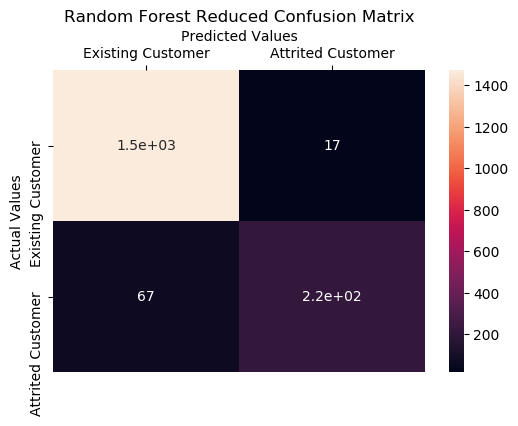

                   precision    recall  f1-score   support

Existing Customer       0.96      0.99      0.97      1489
Attrited Customer       0.93      0.76      0.84       282

         accuracy                           0.95      1771
        macro avg       0.94      0.88      0.90      1771
     weighted avg       0.95      0.95      0.95      1771



In [27]:
# Create and fit a Random Forest Classifier
random_forest_1_model = RandomForestClassifier(n_estimators=50)
random_forest_1_model.fit(X_train, y_train)

# Predict against the test inputs
random_forest_1_predictions = random_forest_1_model.predict(X_test)

# Create and print a confusion matrix
random_forest_1_conf_matrix = confusion_matrix(y_test, random_forest_1_predictions)

column_labels = ['Existing Customer', 'Attrited Customer']
visual_confusion_matrix('Random Forest Reduced Confusion Matrix', 
                        random_forest_1_conf_matrix, 
                        column_labels)

print(classification_report(y_test, random_forest_1_predictions, target_names=column_labels))

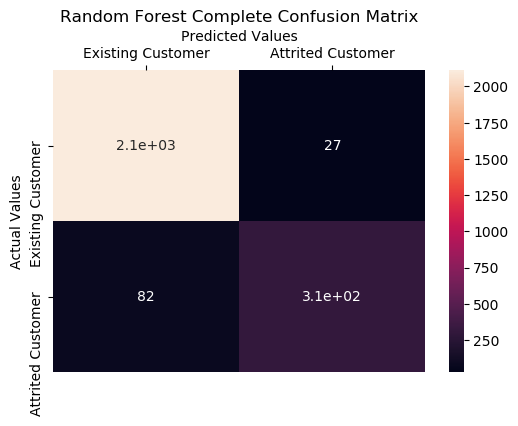

                   precision    recall  f1-score   support

Existing Customer       0.96      0.99      0.97      2139
Attrited Customer       0.92      0.79      0.85       393

         accuracy                           0.96      2532
        macro avg       0.94      0.89      0.91      2532
     weighted avg       0.96      0.96      0.96      2532



In [28]:
# Create and fit a Random Forest Classifier
random_forest_2_model = RandomForestClassifier(n_estimators=50)
random_forest_2_model.fit(X_train_full, y_train_full)

# Predict against the test inputs
random_forest_2_predictions = random_forest_2_model.predict(X_test_full)

# Create and print a confusion matrix
random_forest_2_conf_matrix = confusion_matrix(y_test_full, random_forest_2_predictions)

column_labels = ['Existing Customer', 'Attrited Customer']
visual_confusion_matrix('Random Forest Complete Confusion Matrix', 
                        random_forest_2_conf_matrix, 
                        column_labels)

print(classification_report(y_test_full, random_forest_2_predictions, target_names=column_labels))

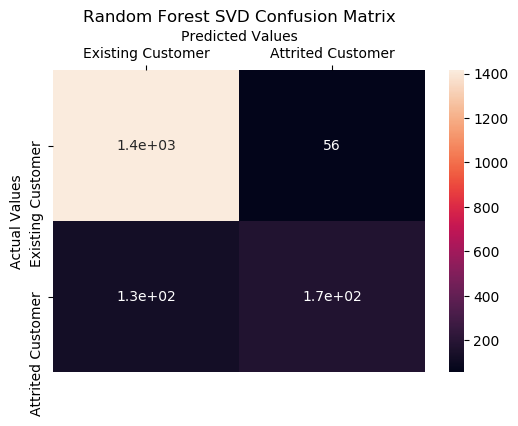

                   precision    recall  f1-score   support

Existing Customer       0.92      0.96      0.94      1471
Attrited Customer       0.76      0.58      0.65       300

         accuracy                           0.90      1771
        macro avg       0.84      0.77      0.80      1771
     weighted avg       0.89      0.90      0.89      1771



In [29]:
# Create and fit a Random Forest Classifier
random_forest_3_model = RandomForestClassifier(n_estimators=50)
random_forest_3_model.fit(X_train_SVD, y_train_SVD)

# Predict against the test inputs
random_forest_3_predictions = random_forest_3_model.predict(X_test_SVD)

# Create and print a confusion matrix
random_forest_3_conf_matrix = confusion_matrix(y_test_SVD, random_forest_3_predictions)

column_labels = ['Existing Customer', 'Attrited Customer']
visual_confusion_matrix('Random Forest SVD Confusion Matrix', 
                        random_forest_3_conf_matrix, 
                        column_labels)

print(classification_report(y_test_SVD, random_forest_3_predictions, target_names=column_labels))

---

## SVM Model

In [30]:
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D

In [31]:
X = df_clean_data[['Total_Trans_Ct', 'Avg_Utilization_Ratio', 'Total_Revolving_Bal']].to_numpy()
Y = df_clean_dummies['Attrition_Flag'].to_numpy()

model = SVC(kernel='linear')
clf = model.fit(X, Y)

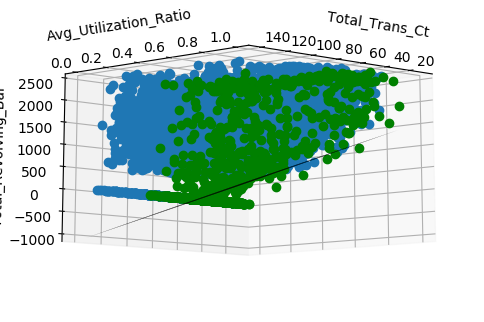

In [32]:
# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

x = np.linspace(20, 140, 30)
y = np.linspace(0, 1, 30)
x,y = np.meshgrid(x,y)

fig = plt.figure()
ax  = fig.gca(projection='3d')
ax.plot(X[Y==0,0], X[Y==0,1], X[Y==0,2], 'o')
ax.plot_surface(x, y, z(x,y), color='black')
ax.plot(X[Y==1,0], X[Y==1,1], X[Y==1,2], 'go')

ax.set_xlabel('Total_Trans_Ct')
ax.set_ylabel('Avg_Utilization_Ratio')
ax.set_zlabel('Total_Revolving_Bal')
ax.view_init(-10, 45)
plt.show()

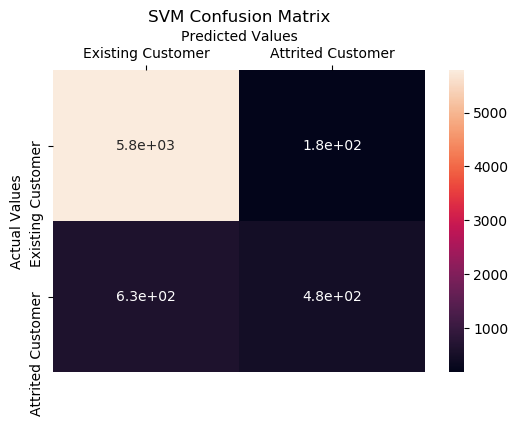

                   precision    recall  f1-score   support

Existing Customer       0.90      0.97      0.93      5968
Attrited Customer       0.72      0.43      0.54      1113

         accuracy                           0.88      7081
        macro avg       0.81      0.70      0.74      7081
     weighted avg       0.87      0.88      0.87      7081



In [33]:
svm_pred = clf.predict(X)

# Create and print a confusion matrix
svm_conf_matrix = confusion_matrix(Y, svm_pred)

column_labels = ['Existing Customer', 'Attrited Customer']
visual_confusion_matrix('SVM Confusion Matrix', 
                        svm_conf_matrix,
                        column_labels)

print(classification_report(Y, svm_pred, target_names=column_labels))

---

## Results

Our Random Forests model was more successful than the SVM model, with much higher precision and recall scores than the SVM model. Through attempting to use SVD for dimensionality reduction, we found that we could get somewhat decent precision and recall scores with less features (4-6), but nothing quite performant enough to run on a larger scale. Since our positive class (attrited customers) was so small, having lower percentage rates on precision and recall translate to large penalties for the number of missed classifications in this class. 

However, using all features, we were able to get much better precision and recall scores, nearly 70-80% on recall and 90%+ on precision. With smaller, unproportional group sizes, these numbers still aren't ideal, and could hopefully be improved with larger numbers of samples for the attrition class.

This ended up proving our hypothesis, showing statistically significant correlations between service utilization metrics and customer attrition. We found that some metrics (such as the total number of transactions and utilization ratio) were statistically significant when predicting customer attrition, allowing for valid predictions to be made with our models.

## Significance of Research

Nearly every business is out to make profit, models like this can help any business - given different factors. Additionally, since it's much cheaper to keep existing customers than find new ones, this research can help a business target at-risk customers to help keep them, through finding useful services for a customer, or identifying why they dislike the product and/or service. Additionally, this research can help to identify how beneficial different products are, and which ones tend to drive customers away. Customers who utilize product A could be compared against customers who use product B, along with their respective attrition rates.

## Potential Future Research

For the future, we believe there are a few target applications and procedures that can be done:

- Gather additional bank customer information around usage, try to find more personal metrics that correlate with attrition
- Look at similar data from other companies (both banks and other industries) to see if metrics are consistent
- Add data about provided services to see if service access correlates to churn
- Explore additional non-linear models to improve results of our models